In [6]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [7]:
#https://www.kaggle.com/crowdflower/twitter-airline-sentiment
#!wget -nc https://lazyprogrammer.me/course_files/AirelineTweets.csv

In [17]:
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import os # accessing directory structure

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [19]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [47]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# Tweets.csv has 14640 rows in reality, but we are only loading/previewing the first 1000 rows
df = pd.read_csv('datastore\Tweets.csv', delimiter=',', nrows = nRowsRead)
df.dataframeName = 'Tweets.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 15 columns


In [48]:
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [49]:
df = df[['airline_sentiment', 'text']].copy()

<Axes: >

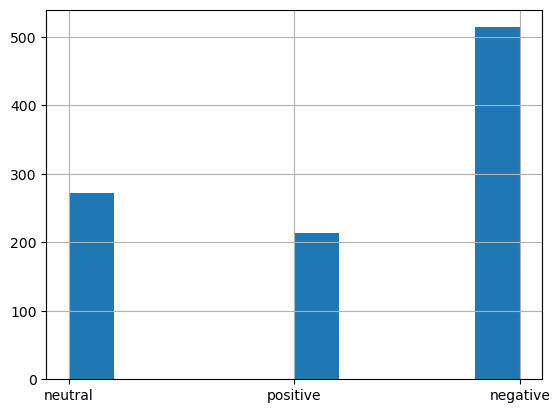

In [50]:
df['airline_sentiment'].hist()

In [51]:
#Filter out rows that have been set as neutral
df = df[df.airline_sentiment != 'neutral'].copy()

In [52]:
#Map labels to integers, could be useful later. start dict and pass in mapping we just created and assign to new column target
target_map = {'positive' : 1, 'negative': 0 }
df['target'] = df['airline_sentiment'].map(target_map)

In [53]:
# See what dataframe looks like now, we have a target column coorsonding to if sentiment was positive or negative
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [56]:
#How many samples we have in dataframe
len(df)

728

In [ ]:
#Use our pretrain classifier to get predictions, grab 
texts = df['text'].tolist()
predictions = classifier(texts)

In [ ]:
predictions

In [ ]:
probs = [d['score] if d['label'].startswith('P') else 1 - d['score'] \ for d in predictions